# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [1]:
# #!L
# from gfile import download_list

# download_list(
#     url='https://drive.google.com/file/d/1F96x4LDbsTZGMMq81fZr7aduJCe8N95O',
#     filename='celeba.zip',
#     target_dir='.'
# )

In [2]:
# #!L:bash
# !unzip celeba.zip

## Prepare the data

In [3]:
#!L
import numpy as np
import time
from pathlib import Path
from shutil import rmtree
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda:0")

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

In [5]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [6]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [7]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='.',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
    download=False
)

validation_dataset = torchvision.datasets.CelebA(
    root='.',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
    download=False
)

In [8]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [9]:
#!L
BATCH_SIZE = 256

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_loader = DataLoader(validation_dataset, num_workers=16, batch_size=BATCH_SIZE)

/home/german.petrov/Desktop/dvg_solutions/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [10]:
#!L
dimZ = 100  # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

def initialize_parameters(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        # TODO
        image_size = (1, 64, 64)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64, 32*32),
            nn.ReLU(),
            nn.Linear(32*32, 16*16),
            nn.ReLU(),
            nn.Linear(16*16, dimZ),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, 16*16),
            nn.ReLU(),
            nn.Linear(16*16, 32*32),
            nn.ReLU(),
            nn.Linear(32*32, 64*64),
            nn.Sigmoid(),
            nn.Unflatten(1, image_size)
        )

    def forward(self, x):

        # TODO
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [11]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder()
autoencoder.apply(initialize_parameters)
autoencoder = autoencoder.to(device)

# Use Adam optimizer
optimizer = optim.AdamW(autoencoder.parameters())

In [12]:
#!L
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

def train_autoencoder(
    autoencoder,
    opt,
    train_dataloader,
    val_dataloader,
    criterion,
    n_epoch
):
    min_loss = np.inf
    Path('weights_ae').mkdir(parents=True, exist_ok=True)
    loss_history = []
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    for epoch in range(n_epoch):
        start_time = time.time()
        
        for x_batch, y_batch in tqdm(train_dataloader):
            opt.zero_grad()
            x_batch = x_batch.to(device)
            
            reconstruction, latent_code = autoencoder(x_batch)
            loss = criterion(reconstruction, x_batch)
            
            # backward
            loss.backward()
            opt.step()
            
            # metrics
            loss_history.append(loss.cpu().data.numpy())
            
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss) 
        
        if min_loss > loss:
            rmtree('weights_ae')
            Path('weights_ae').mkdir(parents=True, exist_ok=True)
            torch.save(autoencoder.state_dict(), f'weights_ae/ae_{loss}_{epoch}.pth')
            min_loss = loss
        scheduler.step()


In [13]:
# train_autoencoder(
#     autoencoder=autoencoder,
#     opt=optimizer,
#     train_dataloader=train_loader,
#     val_dataloader=val_loader,
#     criterion=criterion,
#     n_epoch=30
# )

In [14]:
autoencoder = Autoencoder()
model_path_name = 'weights_pretrained/ae_0.005988882388919592_27.pth'
autoencoder.load_state_dict(torch.load(model_path_name))

autoencoder = autoencoder.to(device)
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=4096, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 64, 64))
  )
)

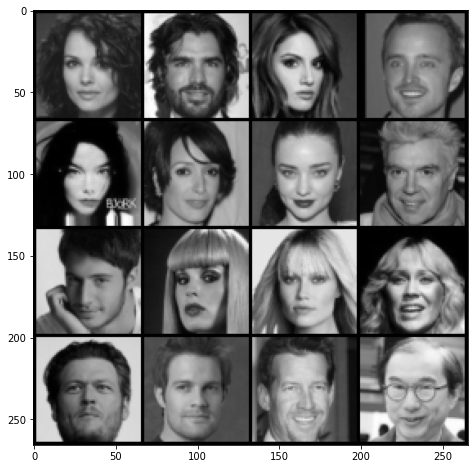

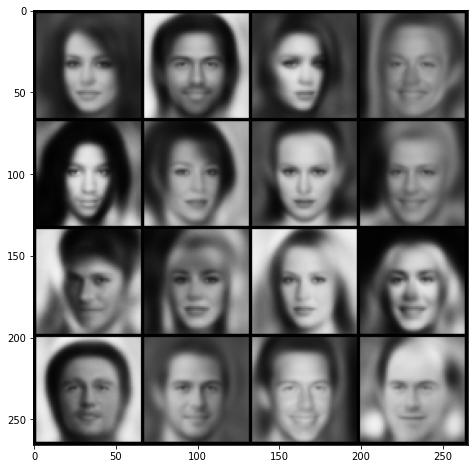

In [15]:
#!L
# Examine the reconstructions
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
plt.show()

reconstruction, latent_code = autoencoder(images.to(device))

reconstruction = reconstruction[:16].cpu()
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
plt.show()

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

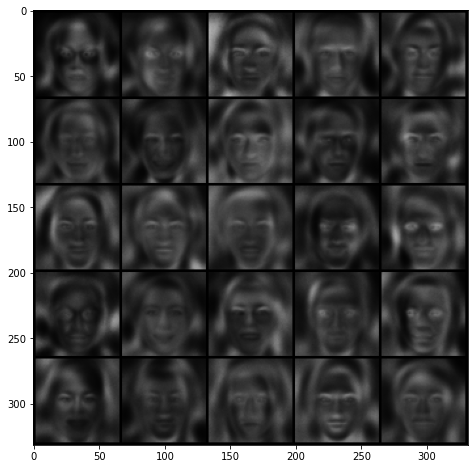

In [16]:
#!L
z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [17]:
#!L
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST


class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        image_size = (1, 64, 64)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64, 32*32),
            nn.ReLU(),
            nn.Linear(32*32, 16*16),
            nn.ReLU(),
        )

        self.encoder_head_1 = nn.Linear(16*16, dimZ)
        self.encoder_head_2 = nn.Linear(16*16, dimZ)
        
        self.decoder_mu = nn.Sequential(
            nn.Linear(dimZ, 16*16),
            nn.ReLU(),
            nn.Linear(16*16, 32*32),
            nn.ReLU(),
            nn.Linear(32*32, 64*64),
            nn.Sigmoid(),
            nn.Unflatten(1, image_size)
        )
        
        self.decoder_logvar = nn.Sequential(
            nn.Linear(dimZ, 16*16),
            nn.ReLU(),
            nn.Linear(16*16, 32*32),
            nn.ReLU(),
            nn.Linear(32*32, 64*64),
            nn.Sigmoid(),
            nn.Unflatten(1, image_size)
        )
        

    def gaussian_sampler(self, mu, logvar):
        noise = torch.randn_like(0.5 * logvar)
        return noise * logvar.exp() + mu
    
    def encode(self, x):
        h = self.encoder(x)
        return self.encoder_head_1(h), self.encoder_head_2(h)
    
    def decode(self, z):
        return self.decoder_mu(z), self.decoder_logvar(z)

    def forward(self, x):
        # TODO
        
        latent_mu, latent_logvar = self.encode(x)
        z = self.gaussian_sampler(latent_mu, latent_logvar)
        reconstruction_mu, reconstruction_logvar = self.decode(z)
        
        return reconstruction_mu, reconstruction_logvar, latent_mu, latent_logvar

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [18]:
#!L
def KL_divergence(mu, logvar):
    kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1), dim=0)
#     kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kld_loss


def log_likelihood(x, mu, logvar):
    likelihood_loss = 0.5 * (mu - x).pow(2) / logvar.exp() + torch.log(logvar.exp().pow(0.5)) + 0.5 * np.log(2 * np.pi)
#     print(likelihood_loss.shape)
    return torch.mean(torch.sum(likelihood_loss, dim=(1, 2, 3)))


def loss_vae(x, mu_gen, logvar_gen, mu_z, logvar_z):
    kld_loss = KL_divergence(mu_z, logvar_z)
#     bce_loss = F.binary_cross_entropy(mu_gen, x, reduction='sum')
    mse_loss = F.mse_loss(mu_gen, x, reduction='sum')
#     likelihood_loss = log_likelihood(x, mu_gen, logvar_gen)
    return kld_loss + mse_loss

And train the model:

In [19]:
#!L
# train your variational autoencoder
# visualize progress in reconstruction and loss decay

In [20]:
def train_vae(
    vae_autoencoder,
    opt,
    train_dataloader,
    val_dataloader,
    n_epoch
):
    min_loss = np.inf
    Path('weights_vae').mkdir(parents=True, exist_ok=True)
    loss_history = []
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    for epoch in range(n_epoch):
        start_time = time.time()
        total_loss = 0
        
        for x_batch, y_batch in tqdm(train_dataloader):
            opt.zero_grad()
            x_batch = x_batch.to(device)
            
            reconstruction_mu, reconstruction_logvar, latent_mu, latent_logvar = vae_autoencoder(x_batch)
            loss = loss_vae(x_batch, reconstruction_mu, reconstruction_logvar, latent_mu, latent_logvar)
            
            # backward
            loss.backward()
            opt.step()
            
            # metrics
#             total_loss += loss.item()
            loss_history.append(loss.cpu().data.numpy())
            
#         # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss) 
        
        if min_loss > loss:
            rmtree('weights_vae')
            Path('weights_vae').mkdir(parents=True, exist_ok=True)
            torch.save(vae_autoencoder.state_dict(), f'weights_vae/vae_{loss}_{epoch}.pth')
            min_loss = loss
        scheduler.step()

In [21]:
#!L
vae_autoencoder = VAE()
vae_autoencoder.apply(initialize_parameters)
vae_autoencoder = vae_autoencoder.to(device)

# Use Adam optimizer
optimizer_vae = optim.AdamW(vae_autoencoder.parameters())

In [22]:
# train_vae(
#     vae_autoencoder=vae_autoencoder,
#     opt=optimizer_vae,
#     train_dataloader=train_loader,
#     val_dataloader=val_loader,
#     n_epoch=20
# )

In [23]:
vae_autoencoder = VAE()
model_path_name = 'weights_pretrained/vae_6138.990234375_17.pth'
vae_autoencoder.load_state_dict(torch.load(model_path_name))

vae_autoencoder = vae_autoencoder.to(device)
vae_autoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU()
  )
  (encoder_head_1): Linear(in_features=256, out_features=100, bias=True)
  (encoder_head_2): Linear(in_features=256, out_features=100, bias=True)
  (decoder_mu): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=4096, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 64, 64))
  )
  (decoder_logvar): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=4096, bias=True)
    (5): Sigmoid()
    (6): Unflatten(

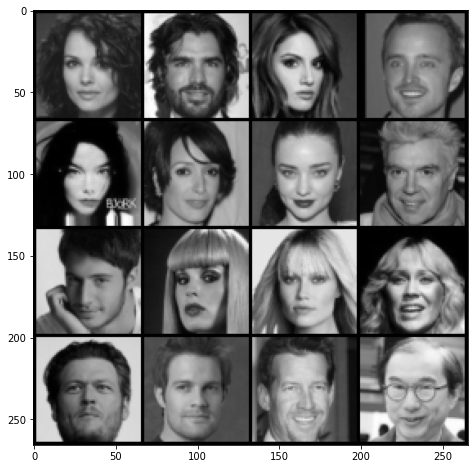

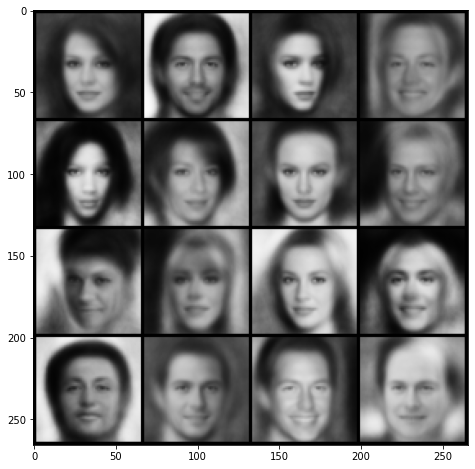

In [24]:
#!L
images, _ = list(islice(val_loader, 1))[0]
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
plt.show()

mu_gen, _, _, _ = vae_autoencoder(images.to(device))
reconstruction = mu_gen[:16].cpu().clamp(0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
plt.show()

And finally sample from VAE.

In [25]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

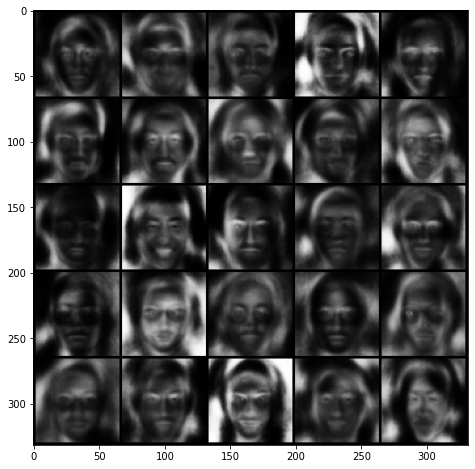

In [32]:
#!L
z = torch.empty(25, dimZ).normal_(mean=0, std=1)
# reconstruction = vae_autoencoder.decode(z.to(device)).clamp(0, 1)
reconstruction, _ = vae_autoencoder.decode(z.to(device))
reconstruction = reconstruction.clamp(0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

4) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

## 1. Create two sets of images

In [48]:
n = 10
idx = 31
images, labels = list(islice(val_loader, 1))[0]

In [78]:
# sample 10 smiling faces
smiling_idx_tuple = torch.where(labels[:, idx] == 1)
smiling_idx = smiling_idx_tuple[0][:n]
smiling_images = images[smiling_idx]

# sample 10 non-smiling faces
non_smiling_idx_tuple = torch.where(labels[:, idx] == 0)
non_smiling_idx = non_smiling_idx_tuple[0][:n]
non_smiling_idx_test = non_smiling_idx_tuple[0][n:2*n]

non_smiling_images = images[non_smiling_idx]
non_smiling_images_test = images[non_smiling_idx_test]

print(f'Smiling images shape: {smiling_images.shape}; smiling indices: {smiling_idx}')
print(f'Non-smiling images shape: {non_smiling_images.shape}; non-smiling indices: {non_smiling_idx}')

Smiling images shape: torch.Size([10, 1, 64, 64]); smiling indices: tensor([ 0,  1,  3,  5,  6,  7, 11, 14, 15, 16])
Non-smiling images shape: torch.Size([10, 1, 64, 64]); non-smiling indices: tensor([ 2,  4,  8,  9, 10, 12, 13, 17, 20, 21])


Smiling images


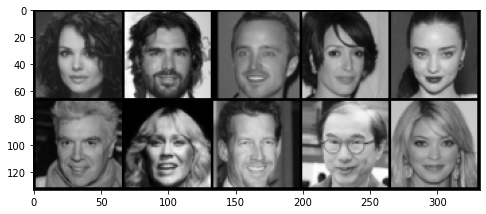

In [79]:
print('Smiling images')
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(smiling_images[:16], nrow=5).permute(1, 2, 0))
plt.show()

Non-smiling images


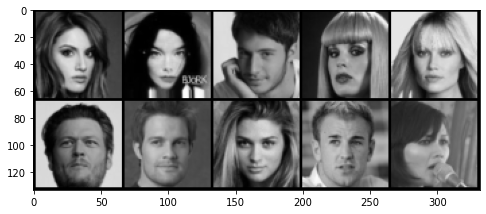

In [80]:
print('Non-smiling images')
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(non_smiling_images[:16], nrow=5).permute(1, 2, 0))
plt.show()

## 2. Compute latent representations

In [106]:
vae_autoencoder = VAE()
model_path_name = 'weights_pretrained/vae_6138.990234375_17.pth'
vae_autoencoder.load_state_dict(torch.load(model_path_name))
vae_autoencoder = vae_autoencoder.eval()

autoencoder = Autoencoder()
model_path_name = 'weights_pretrained/ae_0.005988882388919592_27.pth'
autoencoder.load_state_dict(torch.load(model_path_name))
autoencoder = autoencoder.eval()

In [107]:
def get_vector_representations(
    vae_autoencoder: torch.nn.Module,
    images: torch.Tensor
):
    latent_mu, latent_logvar = vae_autoencoder.encode(images)
    z = vae_autoencoder.gaussian_sampler(latent_mu, latent_logvar)
    
    return torch.mean(z, dim=0)
        
smiling_vector = get_vector_representations(
    vae_autoencoder=vae_autoencoder,
    images=smiling_images
)

non_smiling_vector = get_vector_representations(
    vae_autoencoder=vae_autoencoder,
    images=non_smiling_images
)
print(f'Smiling vector shape: {smiling_vector.shape}')
print(f'Non-smiling vector shape: {non_smiling_vector.shape}')

Smiling vector shape: torch.Size([100])
Non-smiling vector shape: torch.Size([100])


## 3. Compute the difference

In [108]:
diff_vector_smile = smiling_vector - non_smiling_vector

## 4. Add "smile vector to picture"

In [111]:
# And don't forget a smile :)

def add_vector_representation_with_vae(
    vae_autoencoder: torch.nn.Module,
    images: torch.Tensor,
    latent_vector: torch.Tensor
):
    latent_mu, latent_logvar = vae_autoencoder.encode(images)
    z = vae_autoencoder.gaussian_sampler(latent_mu, latent_logvar)
    z_with_latent_vector = z + latent_vector
    reconstruction, _ = vae_autoencoder.decode(z_with_latent_vector)
    
    return reconstruction

def add_vector_representation_with_ae(
    autoencoder: torch.nn.Module,
    images: torch.Tensor,
    latent_vector: torch.Tensor
):
    latent_code = autoencoder.encoder(images)
    z_with_latent_vector = latent_code + latent_vector
    reconstruction = autoencoder.decoder(z_with_latent_vector)
    
    return reconstruction

non_smiling_images_test_vae, _, _, _ = vae_autoencoder(non_smiling_images_test)
reconstruction_vae = non_smiling_images_test_vae.cpu().clamp(0, 1)

images_with_smile_vae = add_vector_representation_with_vae(
    vae_autoencoder=vae_autoencoder,
    images=non_smiling_images_test,
    latent_vector=diff_vector_smile
)

images_with_smile_ae = add_vector_representation_with_ae(
    autoencoder=autoencoder,
    images=non_smiling_images_test,
    latent_vector=diff_vector_smile
)

Non-smiling images


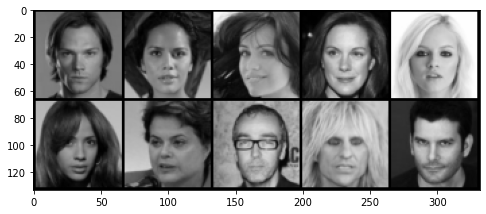

In [112]:
print('Non-smiling images')
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(non_smiling_images_test, nrow=5).permute(1, 2, 0))
plt.show()

Reconstruction from VAE


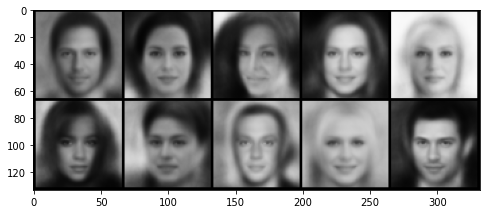

In [113]:
print('Reconstruction from VAE')
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(reconstruction_vae, nrow=5).permute(1, 2, 0))
plt.show()

Smiling images from VAE


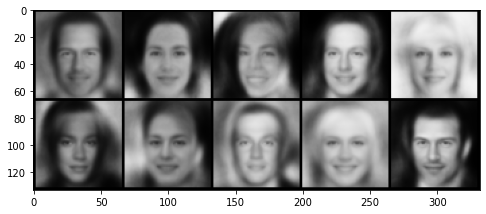

In [102]:
print('Smiling images from VAE')
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images_with_smile_vae, nrow=5).permute(1, 2, 0))
plt.show()

Smiling images from AE


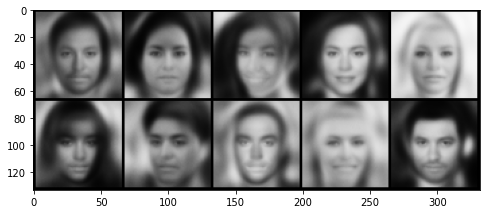

In [114]:
print('Smiling images from AE')
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images_with_smile_ae, nrow=5).permute(1, 2, 0))
plt.show()

<img src="linear.png" alt="linear">